In [3]:
import torchvision
from torchvision import datasets

# Define a convenient location for the dataset
dataset_path = "./mnist_data"

# Download the MNIST dataset
mnist_data = datasets.MNIST(root=dataset_path, download=True)

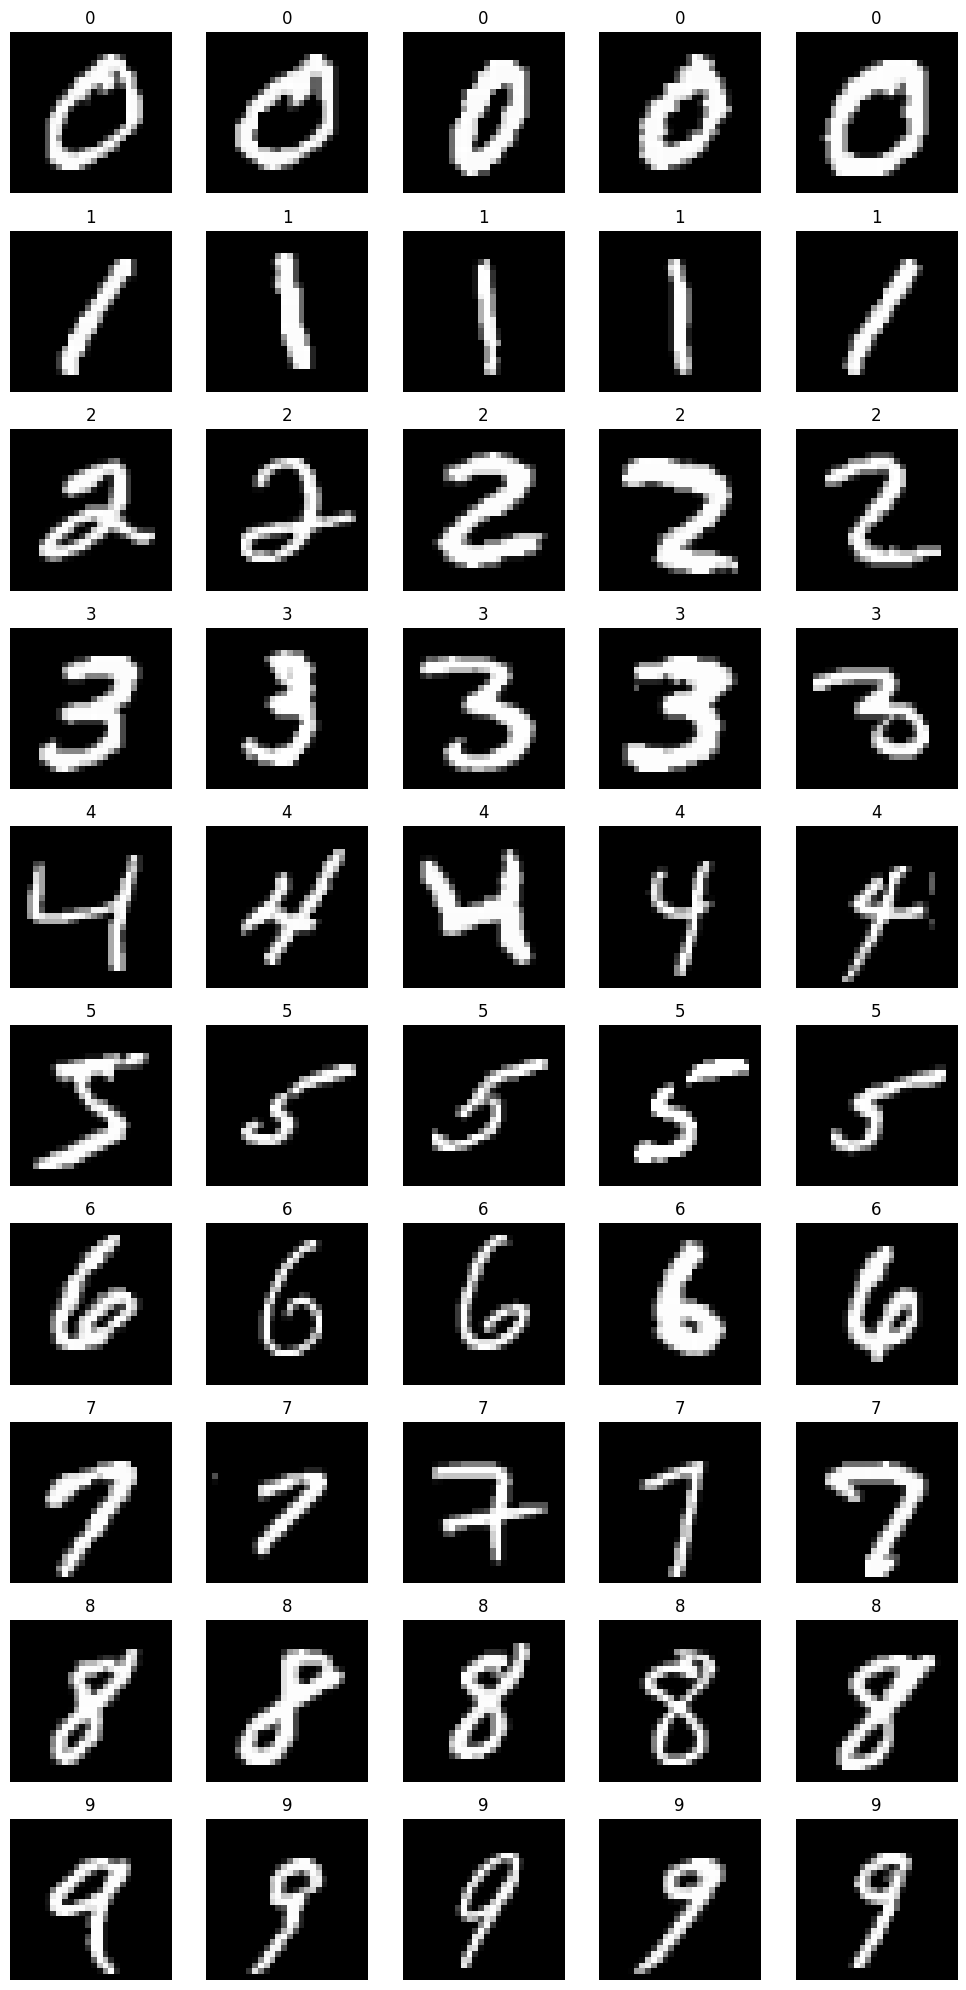

In [4]:
import matplotlib.pyplot as plt
import torch

# Load the dataset (Ensure it's downloaded first)
dataset_path = "./mnist_data"
mnist_data = datasets.MNIST(root=dataset_path, train=True, download=True)

# Extract samples for each class
samples_per_class = 5
classes = list(range(10))
class_images = {digit: [] for digit in classes}

# Go through the dataset and collect samples
for img, label in mnist_data:
    if len(class_images[label]) < samples_per_class:
        class_images[label].append(img)
    if all(len(class_images[digit]) >= samples_per_class for digit in classes):
        break  # Stop once we have enough samples for each class

# Plot images for each class
fig, axes = plt.subplots(nrows=10, ncols=samples_per_class, figsize=(10, 20))
for digit in classes:
    for i, img in enumerate(class_images[digit]):
        axes[digit, i].imshow(img, cmap="gray")  # Apply grayscale colormap
        axes[digit, i].axis("off")
        axes[digit, i].set_title(f"{digit}", fontsize=12)  # Label the class

plt.tight_layout()
plt.show()

In [5]:
import torch
import torchvision.transforms as transforms
import random
import numpy as np
from torchvision import datasets
from PIL import Image

# Load MNIST dataset
dataset_path = "./mnist_data"
mnist_data = datasets.MNIST(root=dataset_path, train=True, download=True)

# Define transformation
transform = transforms.ToTensor()

# Function to create three-digit numbers
def create_three_digit_samples(mnist_data, num_samples_per_class=4000):
    digit_dict = {str(i): [] for i in range(10)}

    # Organize images by digit
    for img, label in mnist_data:
        digit_dict[str(label)].append(img)

    # Create dataset for numbers 000 to 100
    mnist101_data = []
    for num in range(101):  # '000' to '100'
        num_str = f"{num:03d}"  # Convert to three-digit format
        digit_imgs = [random.choice(digit_dict[d]) for d in num_str]

        # Combine digits into a single image (horizontally)
        combined_img = Image.new("L", (digit_imgs[0].width * 3, digit_imgs[0].height))
        for i, digit_img in enumerate(digit_imgs):
            combined_img.paste(digit_img, (i * digit_imgs[0].width, 0))

        # Add to dataset multiple times to meet sample count
        mnist101_data.extend([transform(combined_img)] * num_samples_per_class)

    return mnist101_data

# Create the MNIST101 dataset
mnist101_samples = create_three_digit_samples(mnist_data)

# Confirm dataset size
print(f"MNIST101 dataset created with {len(mnist101_samples)} samples!")

MNIST101 dataset created with 404000 samples!


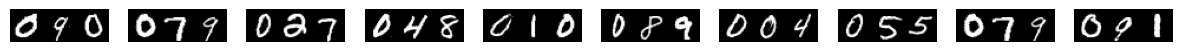

In [6]:
import matplotlib.pyplot as plt

# Select a few random samples to visualize
num_samples_to_display = 10
selected_samples = random.sample(mnist101_samples, num_samples_to_display)

# Plot samples
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 5))
for i in range(num_samples_to_display):
    axes[i].imshow(selected_samples[i].squeeze(), cmap="gray")
    axes[i].axis("off")

plt.show()

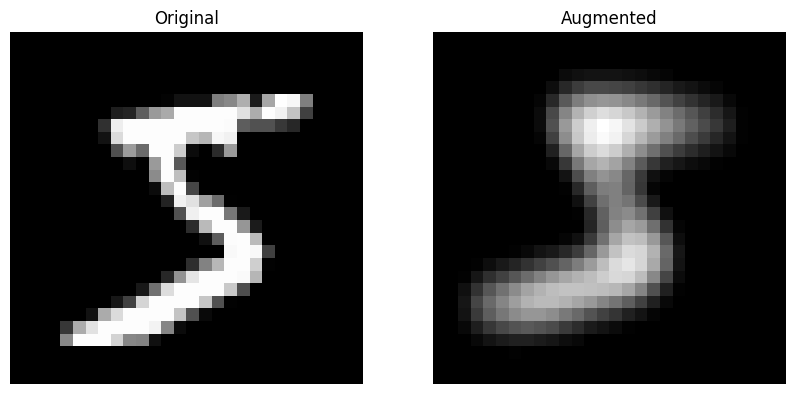

In [19]:
import albumentations as A
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# Define augmentations
augmentations = A.Compose([
    A.Rotate(limit=20, p=0.5),  # Rotate up to ±20 degrees
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),  # Gaussian Blur
    A.MedianBlur(blur_limit=5, p=0.3),  # Median Blur
    A.GaussNoise(p=0.4),  # Gaussian Noise (Fixed)
    A.OpticalDistortion(distort_limit=0.3, p=0.3),  # Elastic Distortion
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),  # Brightness & Contrast
    A.MotionBlur(blur_limit=7, p=0.3),  # Motion Blur
    A.Perspective(scale=(0.05, 0.1), p=0.3),  # Perspective Transform
    A.CLAHE(clip_limit=4, p=0.3),  # Sharpening using CLAHE
    A.CoarseDropout(p=0.3),  # Fixed: No unnecessary arguments
    A.RandomScale(scale_limit=0.2, p=0.3),  # Random Zoom
    A.ToGray(p=0.3),  # Convert to grayscale
    A.InvertImg(p=0.2),  # Invert colors
])

# Function to apply augmentation
def apply_augmentation(image):
    img_array = np.array(image)  # Convert to NumPy array
    augmented = augmentations(image=img_array)['image']  # Apply augmentation
    return Image.fromarray(augmented)  # Convert back to PIL Image

# Test Augmentations
test_img = mnist_data[0][0]  # Get first sample
augmented_img = apply_augmentation(test_img)

# Display Original & Augmented
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_img, cmap="gray")
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(augmented_img, cmap="gray")
ax[1].set_title("Augmented")
ax[1].axis("off")

plt.show()

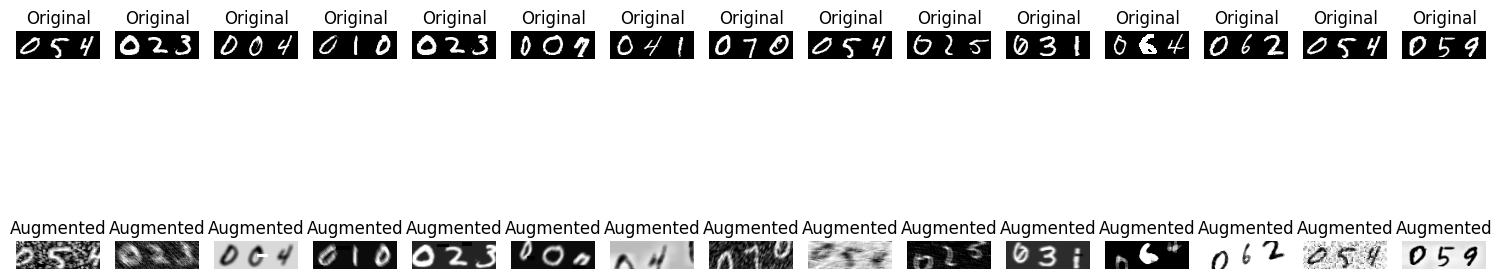

In [27]:
# Display a batch of augmented samples
num_samples = 15
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

# Select random images and apply augmentations
random_indices = np.random.randint(0, len(mnist101_samples), num_samples)
original_samples = [mnist101_samples[i] for i in random_indices]

# Convert Tensor images to PIL format before augmentation
augmented_samples = [apply_augmentation(transforms.ToPILImage()(img)) for img in original_samples]

# Plot images before and after augmentation
for i in range(num_samples):
    # Original Image
    axes[0, i].imshow(original_samples[i].squeeze(0), cmap="gray")  # Fixed: Remove extra dimension
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Augmented Image
    axes[1, i].imshow(augmented_samples[i], cmap="gray")  # Fixed: Augmented images are already PIL
    axes[1, i].axis("off")
    axes[1, i].set_title("Augmented")

plt.tight_layout()
plt.show()

In [28]:
import torch
from torch.utils.data import Dataset
import random
from torchvision import transforms
from PIL import Image

class MNIST101Dataset(Dataset):
    def __init__(self, mnist_data, num_samples_per_class=4000, transform=None):
        """
        Custom dataset class for MNIST101
        :param mnist_data: Original MNIST dataset
        :param num_samples_per_class: Number of samples per class (default 4000)
        :param transform: Optional image transformations
        """
        self.transform = transform
        self.data = []
        self.labels = []

        # Organize MNIST images by digit
        digit_dict = {str(i): [] for i in range(10)}
        for img, label in mnist_data:
            digit_dict[str(label)].append(img)

        # Generate dataset for numbers 000 to 100
        for num in range(101):  # '000' to '100'
            num_str = f"{num:03d}"  # Convert number to three-digit string
            for _ in range(num_samples_per_class):
                digit_imgs = [random.choice(digit_dict[d]) for d in num_str]

                # Combine digits into a single image horizontally
                combined_img = Image.new("L", (digit_imgs[0].width * 3, digit_imgs[0].height))
                for i, digit_img in enumerate(digit_imgs):
                    combined_img.paste(digit_img, (i * digit_imgs[0].width, 0))

                # Apply transformations if provided
                if self.transform:
                    combined_img = self.transform(combined_img)

                self.data.append(combined_img)
                self.labels.append(num)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        return img, label

In [29]:
from torch.utils.data import DataLoader

# Define transformations (resize for consistency)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize pixel values
])

# Create MNIST101 dataset
mnist101_dataset = MNIST101Dataset(mnist_data, num_samples_per_class=4000, transform=transform)

# Create DataLoader for batch processing
mnist101_loader = DataLoader(mnist101_dataset, batch_size=64, shuffle=True)

# Test: Retrieve a batch of images
batch_images, batch_labels = next(iter(mnist101_loader))
print(f"Batch size: {batch_images.shape}, Labels: {batch_labels[:10]}")

Batch size: torch.Size([64, 1, 28, 84]), Labels: tensor([ 6, 85,  1, 17, 70, 60, 28, 11, 41, 62])


In [30]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset

# Define transforms to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test subsets
train_mnist10 = datasets.MNIST(root="./mnist_data", train=True, download=True, transform=transform)
test_mnist10 = datasets.MNIST(root="./mnist_data", train=False, download=True, transform=transform)

In [32]:
import random
from PIL import Image
from torchvision import transforms

def create_mnist101_subset(mnist_data, num_samples_per_class=4000):
    """
    Constructs the MNIST101 dataset subset using MNIST data
    :param mnist_data: MNIST10 subset (train or test)
    :param num_samples_per_class: Number of samples per class (default 4000)
    :return: List of three-digit number images & their labels
    """
    digit_dict = {str(i): [] for i in range(10)}

    # Organize digits in MNIST10 subset
    for img, label in mnist_data:
        digit_dict[str(label)].append(img)

    mnist101_data, mnist101_labels = [], []

    for num in range(101):  # Numbers from "000" to "100"
        num_str = f"{num:03d}"  # Convert to three-digit format
        for _ in range(num_samples_per_class):  # Repeat 4000 times
            # Convert Tensors to PIL Images before processing
            digit_imgs = [transforms.ToPILImage()(random.choice(digit_dict[d])) for d in num_str]

            # Combine digits into a single horizontally stacked image
            combined_img = Image.new("L", (digit_imgs[0].width * 3, digit_imgs[0].height))
            for i, digit_img in enumerate(digit_imgs):
                combined_img.paste(digit_img, (i * digit_imgs[0].width, 0))

            mnist101_data.append(combined_img)
            mnist101_labels.append(num)

    return mnist101_data, mnist101_labels

# Generate MNIST101 Train & Test Subsets
mnist101_train_data, mnist101_train_labels = create_mnist101_subset(train_mnist10)
mnist101_test_data, mnist101_test_labels = create_mnist101_subset(test_mnist10)

In [33]:
from torch.utils.data import Dataset

class MNIST101Dataset(Dataset):
    """
    Custom dataset class for MNIST101
    """
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, label

# Create MNIST101 Train & Test Datasets
mnist101_train_dataset = MNIST101Dataset(mnist101_train_data, mnist101_train_labels, transform=transforms.ToTensor())
mnist101_test_dataset = MNIST101Dataset(mnist101_test_data, mnist101_test_labels, transform=transforms.ToTensor())

In [34]:
from torch.utils.data import DataLoader

# Load Data with DataLoader
train_loader = DataLoader(mnist101_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist101_test_dataset, batch_size=64, shuffle=False)

# Test: Retrieve a batch
train_batch_images, train_batch_labels = next(iter(train_loader))
print(f"Train Batch: {train_batch_images.shape}, Labels: {train_batch_labels[:10]}")

test_batch_images, test_batch_labels = next(iter(test_loader))
print(f"Test Batch: {test_batch_images.shape}, Labels: {test_batch_labels[:10]}")

Train Batch: torch.Size([64, 1, 28, 84]), Labels: tensor([91, 45, 98, 33, 11, 45, 41, 60, 23, 58])
Test Batch: torch.Size([64, 1, 28, 84]), Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [35]:
import collections

# Count occurrences of each label
train_counts = collections.Counter(mnist101_train_labels)
test_counts = collections.Counter(mnist101_test_labels)

# Print class distributions
print("MNIST101 Train Class Counts:", dict(train_counts))
print("MNIST101 Test Class Counts:", dict(test_counts))

MNIST101 Train Class Counts: {0: 4000, 1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000, 9: 4000, 10: 4000, 11: 4000, 12: 4000, 13: 4000, 14: 4000, 15: 4000, 16: 4000, 17: 4000, 18: 4000, 19: 4000, 20: 4000, 21: 4000, 22: 4000, 23: 4000, 24: 4000, 25: 4000, 26: 4000, 27: 4000, 28: 4000, 29: 4000, 30: 4000, 31: 4000, 32: 4000, 33: 4000, 34: 4000, 35: 4000, 36: 4000, 37: 4000, 38: 4000, 39: 4000, 40: 4000, 41: 4000, 42: 4000, 43: 4000, 44: 4000, 45: 4000, 46: 4000, 47: 4000, 48: 4000, 49: 4000, 50: 4000, 51: 4000, 52: 4000, 53: 4000, 54: 4000, 55: 4000, 56: 4000, 57: 4000, 58: 4000, 59: 4000, 60: 4000, 61: 4000, 62: 4000, 63: 4000, 64: 4000, 65: 4000, 66: 4000, 67: 4000, 68: 4000, 69: 4000, 70: 4000, 71: 4000, 72: 4000, 73: 4000, 74: 4000, 75: 4000, 76: 4000, 77: 4000, 78: 4000, 79: 4000, 80: 4000, 81: 4000, 82: 4000, 83: 4000, 84: 4000, 85: 4000, 86: 4000, 87: 4000, 88: 4000, 89: 4000, 90: 4000, 91: 4000, 92: 4000, 93: 4000, 94: 4000, 95: 4000, 96: 4000, 97: 4000, 

In [36]:
# Retrieve one batch from train and test sets
train_batch_images, train_batch_labels = next(iter(train_loader))
test_batch_images, test_batch_labels = next(iter(test_loader))

# Print dataset properties
print(f"Train Batch Size: {train_batch_images.shape}, Labels: {train_batch_labels[:10]}")
print(f"Test Batch Size: {test_batch_images.shape}, Labels: {test_batch_labels[:10]}")

Train Batch Size: torch.Size([64, 1, 28, 84]), Labels: tensor([ 5, 60, 16, 31, 75, 54, 85, 56, 54, 90])
Test Batch Size: torch.Size([64, 1, 28, 84]), Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


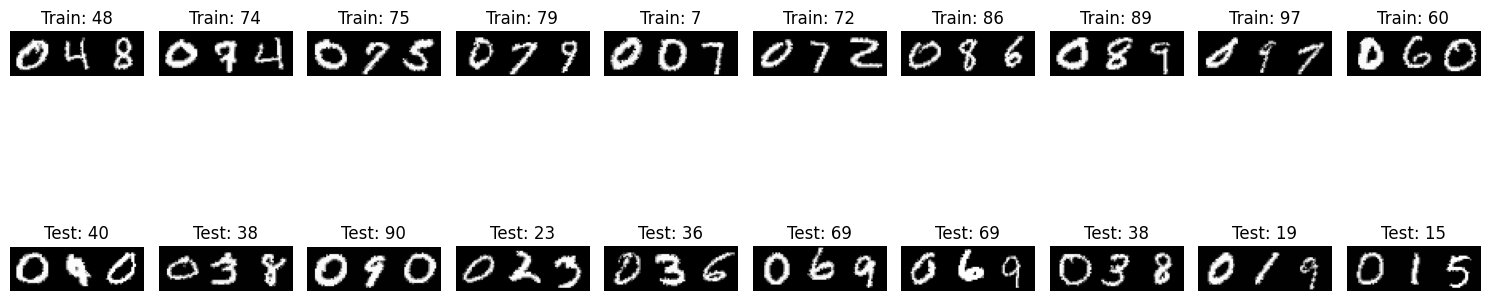

In [37]:
import matplotlib.pyplot as plt

num_samples = 10
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

# Select random train samples
random_indices = torch.randint(0, len(mnist101_train_dataset), (num_samples,))
original_samples = [mnist101_train_dataset[i][0] for i in random_indices]
labels = [mnist101_train_dataset[i][1] for i in random_indices]

# Plot images
for i in range(num_samples):
    axes[0, i].imshow(original_samples[i].squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Train: {labels[i]}")

# Select random test samples
random_indices = torch.randint(0, len(mnist101_test_dataset), (num_samples,))
original_samples = [mnist101_test_dataset[i][0] for i in random_indices]
labels = [mnist101_test_dataset[i][1] for i in random_indices]

for i in range(num_samples):
    axes[1, i].imshow(original_samples[i].squeeze(), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Test: {labels[i]}")

plt.tight_layout()
plt.show()

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define an MLP model for MNIST101
class MNIST101MLP(nn.Module):
    def __init__(self):
        super(MNIST101MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 84, 512)  # Input layer
        self.fc2 = nn.Linear(512, 256)      # Hidden layer
        self.fc3 = nn.Linear(256, 101)      # Output layer (101 classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here since we'll use CrossEntropyLoss
        return x

# Initialize model
model = MNIST101MLP()

In [39]:
# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

# Train model on MNIST101
train_model(model, train_loader)

Epoch [1/5], Loss: 2936.1721
Epoch [2/5], Loss: 922.7839
Epoch [3/5], Loss: 556.8404
Epoch [4/5], Loss: 415.1704
Epoch [5/5], Loss: 339.2186


In [40]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate trained model on MNIST101 test set
evaluate_model(model, test_loader)

Test Accuracy: 93.95%


In [41]:
import torch

# Save the trained model
torch.save(model.state_dict(), "mnist101_mlp.pth")

In [42]:
from google.colab import files
files.download("mnist101_mlp.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
import pickle

# Save datasets
with open("mnist101_train.pkl", "wb") as f:
    pickle.dump((mnist101_train_data, mnist101_train_labels), f)

with open("mnist101_test.pkl", "wb") as f:
    pickle.dump((mnist101_test_data, mnist101_test_labels), f)

In [45]:
files.download("mnist101_train.pkl")
files.download("mnist101_test.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>